TESTED FEATURES: 
Index(['FT', 'vel5', 'vel10', 'vel15', 'vel30', 'vel60', 'acc5', 'acc10',
       'acc15', 'acc30', 'acc60', 'stoch12', 'stochDiff6012', 'RSIhl_diff',
       'RSIhl_diffROC', 'YM_diff', 'NQ_diff', 'vol', 'vol10', 'vol15', 'vol30',
       'vol60', 'volD10', 'volD15', 'volD30', 'volD60', 'volNQdiff',
       'volYMdiff', 'vpm5', 'vpm10', 'vpm15', 'vpm30', 'vpm60', 'ToD', 'DoW',
       'MO'],
      dtype='object')
TESTING FOR: 
MOVE
OCCURANCES IN RAW DATA FOR MOVE: 
{'mv': 12321, 'nm': 12330}
Smallest Class Size: 3223 

OCCURANCES IN OPT DATA FOR MOVE: 
{'mv': 3223, 'nm': 3223}
Epoch 1/50
150/162 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5847 - loss: 0.3370 - precision: 0.5810 - recall: 0.6158
Epoch 1 - Train Accuracy: 0.6057 - Val Accuracy: 0.6000
162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5862 - loss: 0.3366 - precision: 0.5827 - recall: 0.6161 - val_accuracy: 0.6000 - val_loss: 0.6485 - val_precision: 0.5868 - val_recall: 0.6760
Epoch 2/50
159/162 ━━━━━

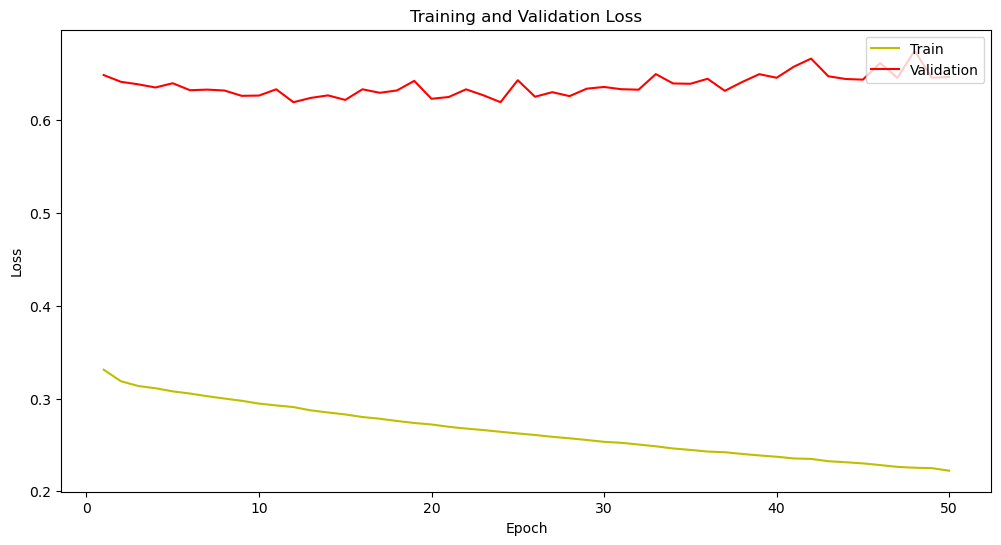

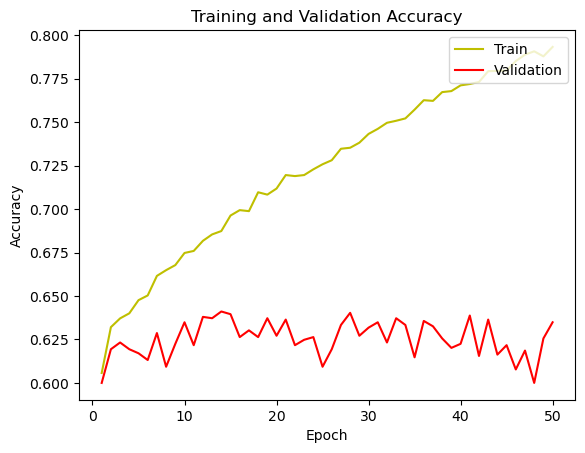

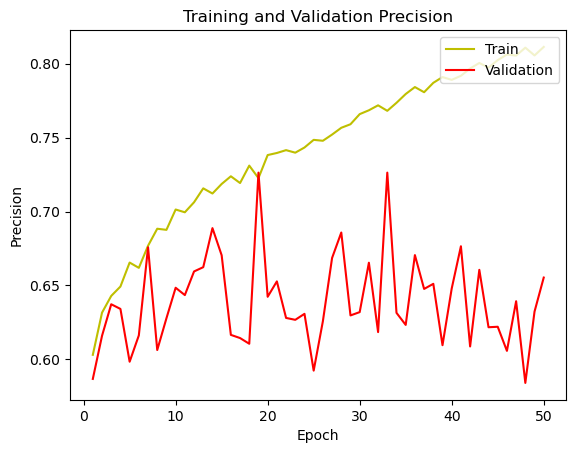

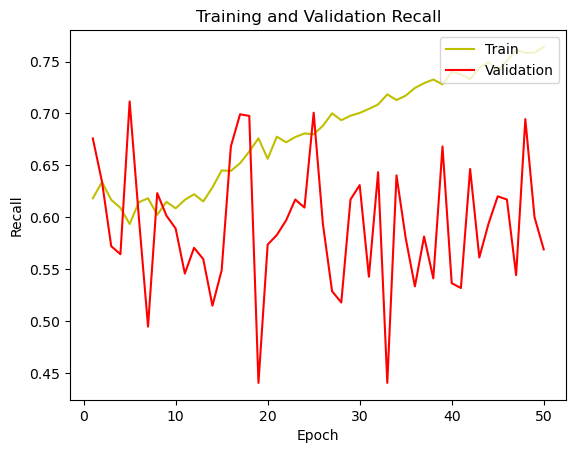

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


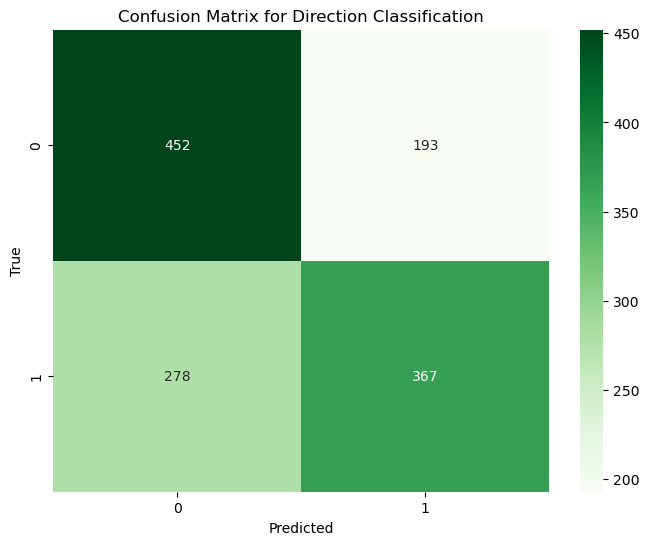

In [15]:
#JJ McCauley + LOGAN KELSCH 
#TEST NN 1

#IMPORT LIBRARIES-------------------------------------------------------

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from keras.optimizers import SGD
from keras.initializers import GlorotUniform
from keras.initializers import RandomNormal
from keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE

#hahaha dont turn this on with high epoch or else
#tf.config.experimental.set_memory_growth

#LOAD DATA FROM CSV-------------------------------------------------------

# Load the dataset
data = pd.read_csv('catted_4.csv')

#      'MOVE' 'DIR'
testFor = 'MOVE'
#testing random feature drops
#TREND
'''
#data = data.drop(columns='FT')
data = data.drop(columns='vel5')
data = data.drop(columns='vel10')
data = data.drop(columns='vel15')
data = data.drop(columns='vel30')
data = data.drop(columns='vel60')
data = data.drop(columns='acc5')
data = data.drop(columns='acc10')
data = data.drop(columns='acc15')
data = data.drop(columns='acc30')
data = data.drop(columns='acc60')
data = data.drop(columns='stoch12')
data = data.drop(columns='stochDiff6012')
data = data.drop(columns='RSIhl_diff')
data = data.drop(columns='RSIhl_diffROC')
data = data.drop(columns='YM_diff')
data = data.drop(columns='NQ_diff')
'''
#PARTICIPATION

'''
#data = data.drop(columns='vol')
data = data.drop(columns='vol10')
data = data.drop(columns='vol15')
data = data.drop(columns='vol30')
data = data.drop(columns='vol60')
data = data.drop(columns='volD10')
data = data.drop(columns='volD15')
data = data.drop(columns='volD30')
data = data.drop(columns='volD60')
data = data.drop(columns='volNQdiff')
data = data.drop(columns='volYMdiff')
data = data.drop(columns='vpm5')
data = data.drop(columns='vpm10')
data = data.drop(columns='vpm15')
data = data.drop(columns='vpm30')
data = data.drop(columns='vpm60')
#data = data.drop(columns='ToD')
#data = data.drop(columns='DoW')
'''
#CALENDAR


#--------------------------------------
#SOLUTION------------------------------
match testFor:
    case 'MOVE':
        data = data.drop(columns='DIR')
    case _:
        data = data.drop(columns='MOVE')


data = data.drop(columns='FT.1')
data = data.drop(columns='FT.2')



#confirming X and Y features post training
Xfeatures = data.columns[:-1]
Yfeatures = data.columns[-1]
print("TESTED FEATURES: ")
print(Xfeatures)
print("TESTING FOR: ")
print(Yfeatures)

#DATA OPTIMIZATION------------------------------------------------------

print("OCCURANCES IN RAW DATA FOR ", Yfeatures, ": ", sep='')
unique, counts = np.unique(data.iloc[:, -1].values, return_counts=True)
print(dict(zip(unique,counts)))

#filtering before splitting could be useful if ABSOLUTELY mostly comprised of 'in'
#MARKET HOURS!
#data = data.drop(data[data['ToD'] > 950].index)
#data = data.drop(data[data['ToD'] < 560].index)
#OTHER MODIFICATIONS
#data = data.drop(data[data['feature'] condition].index)
data = data.drop(data[data['MO'] < 1].index)

match testFor:
    case 'DIR':
        upRows = data.drop(data[data['DIR'] != 'up'].index)
        dnRows = data.drop(data[data['DIR'] != 'dn'].index)
        smallestClass = min(upRows.index.size, dnRows.index.size)
        upRows = upRows.iloc[0:smallestClass]
        dnRows = dnRows.iloc[0:smallestClass]
        optData = pd.concat([upRows, dnRows],axis=0)
    case _:
        mvRows = data.drop(data[data['MOVE'] != 'mv'].index)
        nmRows = data.drop(data[data['MOVE'] != 'nm'].index)
        smallestClass = min(mvRows.index.size, nmRows.index.size)
        mvRows = mvRows.iloc[0:smallestClass]
        nmRows = nmRows.iloc[0:smallestClass]
        optData = pd.concat([mvRows, nmRows],axis=0)
print('Smallest Class Size:',smallestClass,'\n')


print("OCCURANCES IN OPT DATA FOR ", Yfeatures, ": ", sep='')
unique, counts = np.unique(optData.iloc[:, -1].values, return_counts=True)
print(dict(zip(unique,counts)))


#percIn = data.size/(mvRows.size*2)
#percNin = data.size/(nmRows.size*2)
weight_for_0 = .5
weight_for_1 = .5
cw = {0: weight_for_0, 1: weight_for_1}
classWeights = list(cw.values())

#PROCESS THE DATA-------------------------------------------------------

# Separate features and target
X = optData.iloc[:, :-1].values
y = optData.iloc[:, -1].values

#SMOTE OVERSAMPLING________________

#smote = SMOTE()
#X, y = smote.fit_resample(X,y)
#print('\n[PRE-SPLIT] Resampled Data size:',X.size,'--',y.size)

#__________________________________

#Encoding data
labelencoder = LabelBinarizer()
y = labelencoder.fit_transform(y)

# Standardize the features
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# one-hot encode ? 

#from tensorflow.keras.utils import to_categorical
#y_train = to_categorical(y_train, num_classes=4)
#y_test = to_categorical(y_test, num_classes=4)

#RESAMPLED DATA- POST SPLIT---------------------------------------------------------

#smote = SMOTE()
#X_resampled, y_resampled = smote.fit_resample(X_train,y_train)
#print('\nResampled Data size:',X_resampled.size)

#BUILD THE NEURAL NETWORK MODEL-------------------------------------------------------

#CUSTOM CALLBACK FOR PRECISION RATIO TRAINING VS VALIDATION--------------------------------------------------

from tensorflow.keras import backend as K

metric_ratio = tf.Variable(1.0, dtype=tf.float32, name="metric_ratio")

class MetricBalancingCallback(tf.keras.callbacks.Callback):
    def __init__(self, metric='accuracy'):
        super(MetricBalancingCallback, self).__init__()
        self.metric = metric
        self.train_metric = 0
        self.val_metric = 0
        
    def on_epoch_end(self, epoch, logs=None):
        # Based on the metric, get corresponding values from logs
        #print(f"\nEpoch {epoch + 1} logs: {logs}")
        if self.metric == 'precision':
            self.train_metric = logs.get('precision')
            self.val_metric = logs.get('val_precision')
        elif self.metric == 'recall':
            self.train_metric = logs.get('recall')
            self.val_metric = logs.get('val_recall')
        elif self.metric == 'accuracy':
            self.train_metric = logs.get('accuracy')
            self.val_metric = logs.get('val_accuracy')
        
        # Optionally print the values for monitoring
        print(f"\nEpoch {epoch + 1} - Train {self.metric.capitalize()}: {self.train_metric:.4f} - Val {self.metric.capitalize()}: {self.val_metric:.4f}")
        # Dynamically adjust the metric ratio
        #global metric_ratio
        if self.val_metric and self.train_metric:
            ratio = self.train_metric / (self.val_metric + 1e-7)
        else:
            ratio = 1.0  # Fallback in case metrics aren't available

        # Store metric_ratio globally using Keras backend
        K.set_value(metric_ratio,ratio)
        #K.set_value(self.metric_ratio_var, ratio)
    
    def on_train_begin(self, logs=None):
        # Initialize the metric_ratio variable in the backend at the beginning of training
        self.metric_ratio_var = K.variable(1.0, name="metric_ratio")
        

from keras.saving import get_custom_objects
from keras.saving import register_keras_serializable

get_custom_objects().clear()
@register_keras_serializable(name="loss_PunishReward")
def loss_PunishReward(y_true, y_pred):
        
    # Standard binary cross-entropy
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        
    # Define penalties for false negatives (y_true = 1, y_pred = 0)
    false_negatives_penalty = 0.0  # Penalty for false negatives
    false_positives_penalty = 2.0  # Penalty for false positives
        
    # Define reward for true positives (y_true = 1, y_pred = 1)
    true_positives_reward = -1.0  # Negative value to reduce the loss when TP happens

    # Calculate false negatives and false positives
    false_negatives = y_true * (1 - y_pred)
    false_positives = (1 - y_true) * y_pred
        
    # Calculate true positives
    true_positives = y_true * y_pred
        
    # Apply penalties and rewards
    penalties = false_negatives_penalty * false_negatives + false_positives_penalty * false_positives
    rewards = true_positives_reward * true_positives
        
    # Return combined loss (penalize FNs and FPs, reward TPs)
    return bce + penalties + rewards
'''
#CUSTOM LOSS 2____________________________________________________________________________________________________
@register_keras_serializable(name="focal_loss")
def focal_loss(gamma=2.0):
    """
    Parameters:
    - gamma: Focusing parameter that adjusts the rate at which easy examples are down-weighted.
             Default value is 2. Higher values make the loss more focused on hard examples.
             
    - alpha: Class balancing factor to balance the loss for each class. Default is 0.25.
             Adjust this to address class imbalance. Can be a scalar or a list of weights
             per class.
    """
    #gamma = 2.0
    alpha = classWeights
 
    @register_keras_serializable(name="focal_loss_fixed")
    def focal_loss_fixed(y_true, y_pred):
        """
        Compute the focal loss between ground truth (y_true) and predicted values (y_pred).
        
        Arguments:
        - y_true: Tensor of true labels (one-hot encoded, shape = [batch_size, num_classes]).
        - y_pred: Tensor of predicted probabilities (shape = [batch_size, num_classes]).
        
        Returns:
        - loss: A scalar tensor representing the computed focal loss.
        """
        # Clip predictions to prevent log(0) or division by zero
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1. - tf.keras.backend.epsilon())
        
        # Compute the cross-entropy loss (standard loss component)
        cross_entropy_loss = -y_true * tf.math.log(y_pred)
        
        # Compute the modulating factor: (1 - p_t)^gamma
        # where p_t is the predicted probability for the true class
        modulating_factor = tf.pow(1. - y_pred, gamma)
        
        # Compute the final focal loss: alpha * modulating_factor * cross_entropy_loss
        loss = alpha * modulating_factor * cross_entropy_loss
        
        # Reduce the loss along the batch dimension
        return tf.reduce_mean(tf.reduce_sum(loss, axis=-1))
    
    return focal_loss_fixed
#CUSTOM LOSS 3_____________________________________________________________________________________________
@register_keras_serializable(name="weighted_rec_pre_loss")
def weighted_rec_pre_loss(func='wr',weight=5.0):
    """
    Custom loss function to optimize for recall OR for precision.
    func should equal wr or wp
    for weighted recall or weighted precision
    """
    @register_keras_serializable(name='wp_loss')
    def wp_loss(y_true, y_pred):
        # Clip predictions to prevent log(0) or division by zero
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        # Standard binary cross-entropy
        base_loss = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)
        # Apply higher weight to positive samples (to penalize false negatives more)
        loss = (1 - y_true) * weight * base_loss + y_true * base_loss
        return tf.reduce_mean(loss)
    
    @register_keras_serializable(name="wr_loss")
    def wr_loss(y_true, y_pred):
        # Clip predictions to prevent log(0) or division by zero
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        # Standard binary cross-entropy
        base_loss = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)
        # Apply higher weight to positive samples (to penalize false negatives more)
        loss = weight * y_true * base_loss + (1 - y_true) * base_loss
        return tf.reduce_mean(loss)
    
    
    
    if(func=='wr'):
        return wr_loss
    else:
        return wp_loss
'''
#CUSTOM LOSS 4_____________________________________________________________________________________________
#metric_ratio = 1.0  # Initialize globally
@register_keras_serializable(name="met_ratio")
def met_ratio(y_true, y_pred, base_weight=1.0):
    crnt_metric_ratio = metric_ratio
    
    # Clip predictions to prevent log(0) or division by zero
    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
    
    # Standard binary cross-entropy loss
    base_loss = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)
    
    # Adjust weight using precision_ratio (balance training and validation precision)
    adjusted_weight = base_weight / (crnt_metric_ratio + 1e-7)
    
    # Apply the dynamic weight to false positives
    weighted_loss = (1 - y_true) * adjusted_weight * base_loss + y_true * base_loss
    
    return tf.reduce_mean(weighted_loss)

#END CUSTOM LOSSES__________________________________________________________________________________________

#LEARNING RATES____________________________________________________________________________________________
from keras.optimizers.schedules import ExponentialDecay
lr_schedule = ExponentialDecay(
    #good rough val to start, .25, good val to end at .0015.
    #5k epoch should be: .25, 8565, .9995, true
    0.05,
    decay_steps=186,
    decay_rate=.96,
    staircase=True)

opt1 = SGD(learning_rate=0.0001)
opt2  = tf.keras.optimizers.Adam(clipnorm=0.01)
opt3 = SGD(learning_rate=lr_schedule)

#BUILD AND LOAD MODEL__________________________________________________________________________________________

metric_callback = MetricBalancingCallback(metric='accuracy')

def build_model():
    model = tf.keras.Sequential([#currently 17 total features
        tf.keras.layers.Dense(2048),#,kernel_initializer='he_normal',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('leaky_relu'),
        #tf.keras.layers.Dropout(0.40),
        tf.keras.layers.Dense(1024),#,kernel_initializer='he_normal',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('leaky_relu'),
        #tf.keras.layers.Dropout(0.40),
        tf.keras.layers.Dense(512),#,kernel_initializer='he_normal',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('leaky_relu'),
        #tf.keras.layers.Dropout(0.40),
        #tf.keras.layers.Dense(64),#, kernel_regularizer=tf.keras.regularizers.l2(0.05)),
        #tf.keras.layers.BatchNormalization(),
        #tf.keras.layers.Activation('leaky_relu'),
        #tf.keras.layers.Dropout(0.04),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    #AUC=tf.keras.metrics.AUC(curve='PR')
    met = ['precision','recall','accuracy']
    model.compile(optimizer=opt3,
                  loss='binary_crossentropy'
                  ,metrics=met)
    return model



def load_model():
    #loaded_model = tf.keras.models.load_model('tupleTrain.keras', custom_objects={'custom_loss':custom_loss})
    loaded_model = tf.keras.models.load_model('dm_DIR_2.keras')
    met = ['accuracy','precision','recall']
    loaded_model.compile(optimizer=opt3,
                         loss='binary_crossentropy'
                         , metrics=met)
    return loaded_model


#TRAIN THE MODEL WITH CUSTOMIZABLE EPOCHS-------------------------------------------------------

epochs = 50

early_stopping = EarlyStopping(monitor='val_recall', patience=250, mode='max', restore_best_weights=True)

model = build_model()
loaded_model = load_model()
history = model.fit(X_train, y_train, epochs=epochs, validation_split=0.2,\
                    shuffle=True, verbose=1, validation_data=(X_test, y_test),\
                    class_weight=cw, callbacks=[metric_callback])

#EVALUATE THE MODEL AND VISUALIZE RESULTS-------------------------------------------------------

#_, acc = model.evaluate(X_test, y_test)
#print("Accuracy = ", (acc * 100.0), "%")

# LOSS
epochs = range(1, len(history.history['loss']) + 1)
plt.figure(figsize=(12, 6))
plt.plot(epochs, history.history['loss'], 'y', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
# ACCURACY
plt.plot(epochs, history.history['accuracy'], 'y', label='Training acc')
plt.plot(epochs, history.history['val_accuracy'], 'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
'''
# AUC
plt.plot(epochs, history.history['AUC'], 'y', label='Training AUC')
plt.plot(epochs, history.history['val_AUC'], 'r', label='Validation AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC Score')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
'''
# PRECISION
plt.plot(epochs, history.history['precision'], 'y', label='Training Precision')
plt.plot(epochs, history.history['val_precision'], 'r', label='Validation Precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
# RECALL
plt.plot(epochs, history.history['recall'], 'y', label='Training Recall')
plt.plot(epochs, history.history['val_recall'], 'r', label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
# TPR
'''
TPR = history.history['TruePositives']/(history.history['TruePositives']+history.history['TrueNegatives'])
val_TPR = history.history['val_TruePositives']/(history.history['val_TruePositives']+history.history['val_TrueNegatives'])
plt.plot(epochs, TPR, 'y', label='Training TPR')
plt.plot(epochs, val_TPR, 'r', label='Validation TPR')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('TP Rate')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

'''

#predicting the test set results
y_pred = model.predict(X_test) 
y_pred = y_pred > 0.5 # Predictions to class indices

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d',cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Direction Classification')
plt.show()

# Save the model
#model.save('epoch15k.keras')
# Load the model
#loaded_model = tf.keras.models.load_model('my_model.keras')

In [16]:
# Save the model
loaded_model.save('dm_MOVE_V2.keras')

In [34]:
print(X_test[0])
print(X_test[1])
print(X_test[2])

[-0.97195556 -0.00408942 -0.39446173 -0.08356085 -0.91451578 -0.63588848
  0.3737884  -0.13449907  0.7981276  -0.40741038 -0.45716194 -1.49270001
 -0.31298629  1.48191754 -0.01422969  0.37569669 -0.19858359 -0.74333582]
[ 1.49217188e+00  2.66737000e-01 -2.21463041e-03  4.03728139e-01
  1.04248556e-01  3.07783903e-01  3.73788401e-01  1.46388686e-03
  2.87053937e-01 -1.67196904e-01  5.67684603e-01  1.13792970e+00
  1.45646971e+00  6.71344374e-01 -9.47560007e-02  1.81155898e-01
  2.10342354e-01 -2.54478876e-01]
[ 0.3955989  -0.9519819   0.39003247  0.40372814  0.78342478  1.25145629
 -1.60516561  0.2733898  -0.22401973 -0.40741038  1.25091563  0.81992649
  0.98172568  0.11667741  0.06456486  0.1811559   0.21034235 -0.29300947]


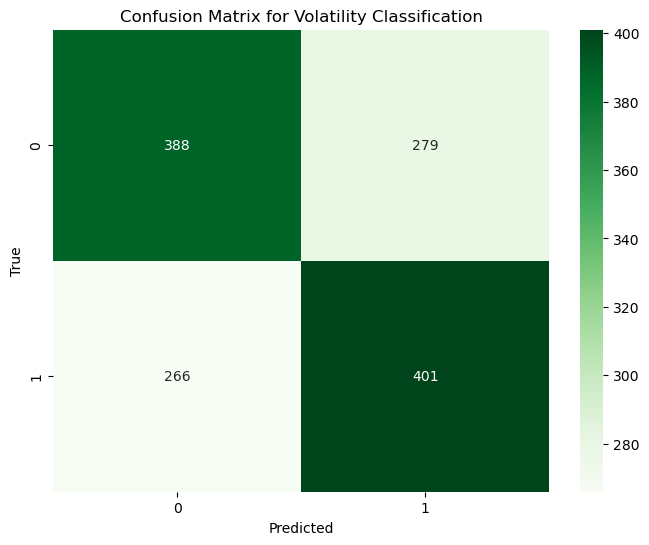

In [8]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d',cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Volatility Classification')
plt.show()

In [88]:
data2 = pd.read_csv('catted_1.csv')
print(data2['DIR'].unique())
print(data2['MOVE'].unique())

['dn' 'up']
['nm' 'mv']


In [6]:
# Import necessary libraries
from tensorflow.keras.models import load_model
from sklearn.model_selection import KFold
import numpy as np

# Load your pre-trained model
model = load_model('dm_DIR_2.keras')

# Assuming you have your data and labels as numpy arrays (X, y)
# X: Features, y: Labels (binary classification: 0 or 1)

# Set the number of folds (e.g., 5-fold cross-validation)
kf = KFold(n_splits=100, shuffle=True, random_state=42)

# Initialize lists to store results
fold_accuracies = []

# Perform K-Fold cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_val = X[train_index], X[test_index]
    y_train, y_val = y[train_index], y[test_index]
    
    # Optionally, reset the model's weights before each fold
    # model.load_weights('path_to_weights') # If you want to use the same weights every time
    
    # Re-train the model on the fold's training data
    model.fit(X_train, y_train, epochs=0, batch_size=32, verbose=1)
    
    # Evaluate on the validation set
    results = model.evaluate(X_val, y_val, verbose=1)

    # Assuming 'results' contains more than just loss and accuracy, you can access them individually
    val_loss = results[0]  # This is typically the loss
    val_accuracy = results[1]  # This is typically accuracy (if it's your second metric)
    fold_accuracies.append(val_accuracy)

# Calculate average accuracy over all folds
average_accuracy = np.mean(fold_accuracies)
print(f'Average accuracy across {kf.n_splits} folds: {average_accuracy:.4f}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9480 - loss: 8.5478 - precision: 0.9694 - recall: 0.9550  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.4719 - precision: 1.0000 - recall: 1.0000 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.4952 - precision: 1.0000 - recall: 1.0000 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.5060 - precision: 1.0000 - recall: 1.0000 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9896 - loss: 8.4915 - precision: 0.9803 - recall: 1.0000 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9636 - loss: 8.5207 - precision: 1.0000 - recall: 0.9438 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9610 - loss: 8.5331 - precision: 1.0000 - recall: 0.9373 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9532 - loss: 8.5368 - precision: 0.9813 - recall: 0.9478 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9818 - loss: 8.4767 - precision: 1.0000 - recall: 0.9719 
3/3 ━━━━━━━━━━━━━━